In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 735418549830589178
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2691675212820122899
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15655820121490028563
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5749887187178090746
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
root = '/content/drive/My Drive/DNAChallenge/'
trainFeatures = root + 'train_values.csv'
trainLabels = root + 'train_labels.csv'
testFeatures = root + 'test_values.csv'
submission = root + 'submission.csv'

In [ ]:
x_train = pd.read_csv(trainFeatures)
y_train = pd.read_csv(trainLabels)

x_test = pd.read_csv(testFeatures)

In [ ]:
x_train

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,BOQSD,AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63013,5XVVU,AACAAAATATTAACGCTTACAATTTCCATTCGCCATTCAGGCTGCG...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63014,CVGHF,CCGGTGGTGCATATCGGGGATGAAAGCTGGCGCATGATGACCACCG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63015,ZVT1A,CTAGCTAGTCCTGCAGGTTTAAACGAATTCGCCCTTTGCTTTCTCT...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train

,sequence_id,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
0,9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,BOQSD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63013,5XVVU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63014,CVGHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63015,ZVT1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

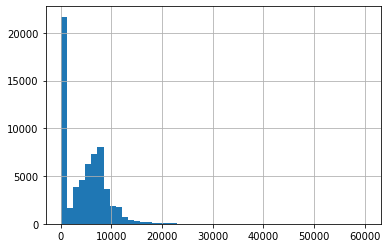

In [ ]:
x_train['sequence'].apply(lambda x: len(list(x))).hist(bins=50)

In [ ]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [ ]:
print(len(getKmers(x_train.loc[0]['sequence'])))
print(len(x_train.loc[0]['sequence']))

7149
7151


In [ ]:
x_train['words'] = x_train.apply(lambda x: getKmers(x['sequence']), axis=1)
x_train = x_train.drop('sequence', axis=1)

KeyboardInterrupt: ignored

In [ ]:
x_train

In [ ]:
x_train = x_train.set_index('sequence_id').join(y_train.set_index('sequence_id'))
target = [x for x in y_train.columns if 'sequence' not in x]
x_train, x_val, y_train, y_val = train_test_split(res, x_train[target], test_size=0.2)

AttributeError: ignored

In [ ]:
#### CNN design
#tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

    '''
    tf.keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    '''

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(embDim,maxSeqLen//embDim,)),

    tf.keras.layers.Conv1D(filters=64, kernel_size=50, activation='relu'),
    tf.keras.layers.MaxPooling1D(),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1314, activation='softmax'),
])

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-03), metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 50)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 256)           192256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11008)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1409152   
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [ ]:
!pip install keras-lr-finder

Epoch 1/5
99/99 [==============================] - 5s 46ms/step - loss: 6.5153 - categorical_accuracy: 0.1301
Epoch 2/5
99/99 [==============================] - 4s 44ms/step - loss: 5.0932 - categorical_accuracy: 0.2014
Epoch 3/5
99/99 [==============================] - 4s 44ms/step - loss: 5.4083 - categorical_accuracy: 0.1450
Epoch 4/5
99/99 [==============================] - 4s 44ms/step - loss: 5.2481 - categorical_accuracy: 0.1415
Epoch 5/5
99/99 [==============================] - 4s 44ms/step - loss: 234.5260 - categorical_accuracy: 0.1086


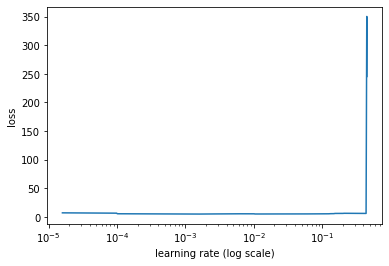

In [ ]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=1, batch_size=512, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=500, validation_data=(x_val, y_val))

Epoch 1/100
101/101 [==============================] - 6s 55ms/step - loss: 5.3881 - categorical_accuracy: 0.1746 - val_loss: 5.0113 - val_categorical_accuracy: 0.1919
Epoch 2/100
101/101 [==============================] - 5s 47ms/step - loss: 4.8058 - categorical_accuracy: 0.2066 - val_loss: 4.8029 - val_categorical_accuracy: 0.2124
Epoch 3/100
101/101 [==============================] - 5s 48ms/step - loss: 4.5417 - categorical_accuracy: 0.2441 - val_loss: 4.5146 - val_categorical_accuracy: 0.2555
Epoch 4/100
101/101 [==============================] - 5s 48ms/step - loss: 4.2578 - categorical_accuracy: 0.2779 - val_loss: 4.2919 - val_categorical_accuracy: 0.2821
Epoch 5/100
101/101 [==============================] - 5s 47ms/step - loss: 3.9974 - categorical_accuracy: 0.3080 - val_loss: 4.1345 - val_categorical_accuracy: 0.3033
Epoch 6/100
101/101 [==============================] - 5s 47ms/step - loss: 3.7575 - categorical_accuracy: 0.3344 - val_loss: 3.9341 - val_categorical_accuracy:

KeyboardInterrupt: ignored

In [ ]:
#### helper plot function


def plot_acc_loss(history):
  plt.plot(history.history['accuracy'], label='acc')
  plt.plot(history.history['val_accuracy'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

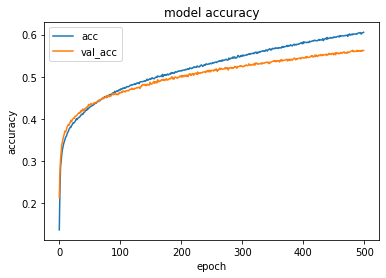

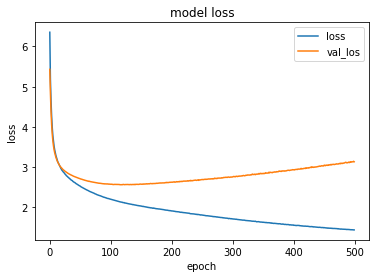

In [ ]:
plot_acc_loss(hist)

In [ ]:
############################ submission phase TODO remove split use all data
submission_data = pd.read_csv(submission)

In [ ]:
x_test['Tdist'] = x_test['sequence'].map(lambda x: list(x).count('T')/len(x))
x_test['Adist'] = x_test['sequence'].map(lambda x: list(x).count('A')/len(x))
x_test['Cdist'] = x_test['sequence'].map(lambda x: list(x).count('C')/len(x))
x_test['Gdist'] = x_test['sequence'].map(lambda x: list(x).count('G')/len(x))
x_test['Ndist'] = x_test['sequence'].map(lambda x: list(x).count('N')/len(x))

In [ ]:
x_test

In [ ]:
test_cols = [x for x in x_test.columns if 'sequence' not in x]

In [ ]:
x_test[test_cols]

In [ ]:
res = model.predict(x_test[test_cols], batch_size=500)

In [ ]:
tmp = np.argmax(res, axis=1)

In [ ]:
output = np.zeros((len(tmp), tmp.max()+1))
output[np.arange(len(tmp)),tmp] = 1

In [ ]:
print(output.shape)
print(submission_data.loc[:, submission_data.columns != 'sequence_id'].shape)

In [ ]:
submission_data.loc[:, submission_data.columns != 'sequence_id'] = output

In [ ]:
submission_data.to_csv(submission, index=False)

In [ ]:
submission_data